Load final versions of datasets with adjustment from preliminary feature importance evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Load final versions of datasets
df_final = pd.read_csv("datasets/churn_preprocessed_train_final.csv")

cols_state_area = df_final.columns[df_final.columns.str.contains('state|area_code')]

df_final_v3 = df_final.drop(columns=cols_state_area)
df_final_v3 = df_final_v3.drop(columns=['voice_mail_plan', 'intl_charge_per_min_cate'])

# df_final_v3.to_csv('churn_preprocessed_test_final.csv', index=False)

# define train dataset
X_train_final = df_final_v3.drop(columns=['churn'])
y_train_final = df_final_v3['churn']

# define holdout dataset
test_data_v3 = pd.read_csv('datasets/churn_preprocessed_test_final.csv')
X_test_final = test_data_v3.drop(columns=['churn'])
y_test_final = test_data_v3['churn']

In [3]:
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from statistics import mean
from datetime import datetime

## Model Construction

### AutoML Screening

In [4]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.5+9-LTS-239, mixed mode, sharing)
  Starting server from C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ACER\AppData\Local\Temp\tmpiqi8vig1
  JVM stdout: C:\Users\ACER\AppData\Local\Temp\tmpiqi8vig1\h2o_ACER_started_from_python.out
  JVM stderr: C:\Users\ACER\AppData\Local\Temp\tmpiqi8vig1\h2o_ACER_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Ho_Chi_Minh
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_ACER_1sseck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.911 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [5]:
automl_data = h2o.H2OFrame(pd.concat([X_train_final, y_train_final], axis=1))
automl_data["churn"] = automl_data["churn"].asfactor()

X_automl = pd.concat([X_train_final, y_train_final], axis=1).columns.drop('churn').tolist()
y_automl = "churn"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
# Run H2O AutoML
aml = H2OAutoML(
    max_models=20,        
    seed=42, 
    max_runtime_secs=300,
    exclude_algos=["DeepLearning","StackedEnsemble"],
    nfolds=5
)
aml.train(x=X_automl, y=y_automl, training_frame=automl_data)
lb = aml.leaderboard
print(lb)

AutoML progress: |
14:46:45.997: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse        mse
GBM_grid_1_AutoML_1_20241205_144645_model_5   0.929914   0.156249  0.87293                0.104742   0.190809  0.0364081
GBM_3_AutoML_1_20241205_144645                0.926514   0.156696  0.871147               0.110775   0.192963  0.0372348
GBM_2_AutoML_1_20241205_144645                0.924049   0.157111  0.872566               0.116312   0.192969  0.0372371
GBM_4_AutoML_1_20241205_144645                0.923313   0.158048  0.872897               0.113954   0.19202   0.0368718
GBM_grid_1_AutoML_1_20241205_144645_model_8   0.923173   0.168464  0.858709               0.118287   0.199014  0.0396067
GBM_grid_1_AutoML_1_20241205_144645_model_9   0.921246   0.167945  0.869922               0.0956154  0.197843  0.039

In [7]:
aml.leader

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20241205_144645_model_5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    48                 48                          62951                  9            9            9             42            148           99.5625

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.004321964691827907
RMSE: 0.06574165111881437
LogLoss: 0.028217226777952804
Mean Per-Class Error: 0.0004389815627743635
AUC: 0.9999960401147687
AUCPR: 0.9999767450557524
Gini: 0.9999920802295375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24148554666126054
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      2276  2    0.0009   (2.0/2278.0)
1      0     388  0        (0.0/388.0)
Total  2276  390  0.0008   (2.0/2666.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.241486     0.997429  184
max f2                       0.241486     0.99897   184
max f0point5                 0.270416     0.998444  180
max accuracy                 0.263229     0.99925   183
max precision                0.993677     1         0
max recall                   0.241486     1         184
max specificity              0.993677     1         0
max absolute_mcc             0.241486     0.996995  184
max min_per_class_accuracy   0.241486     0.999122  184
max mean_per_class_accuracy  0.241486     0.999561  184
max tns                      0.993677     2278      0
max fns                      0.993677     387       0
max fps                      0.00245041   2278      399
max tps                      0.241486     388       184
max tnr                      0.993677     1         0
max fnr                      0.993677     0.997423  0
max fpr                      0.00245041   1         399
max tpr                      0.241486     1         184

Gains/Lift Table: Avg response rate: 14.55 %, avg score: 14.53 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0101275                   0.987157           6.87113  6.87113            1                0.989354    1                           0.989354            0.0695876       0.0695876                  587.113  587.113            0.0695876
2        0.0202551                   0.984677           6.87113  6.87113            1                0.985804    1                           0.987579            0.0695876       0.139175                   587.113  587.113            0.139175
3        0.0300075                   0.982031           6.87113  6.87113            1                0.98346     1                           0.986241            0.0670103       0.206186                   587.113  587.113            0.206186
4        0.040135                    0.980491           6.87113  6.87113            1                0.981334    1                           0.985003            0.0695876       0.275773                   587.113  587.113            0.275773
5        0.0502626                   0.978283           6.87113  6.87113            1                0.979488    1                           0.98389

In [8]:
# Cross validation sampling for training

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_split = cv.split(X_train_final, y_train_final)

### Base Models Building

In [9]:
# Calculate scale_pos_weight to handle class imbalance
negative_count_final = np.sum(y_train_final == 0)
positive_count_final = np.sum(y_train_final == 1)
scale_pos_weight_final = negative_count_final / positive_count_final

# Define parameter space for BayesSearchCV
param_space_lgbm_final = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5)
}

param_space_xgb_final = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5),
    'tree_method': ['auto']
}

param_space_cb_final = {
    'iterations': (100, 200),
    'depth': (3, 10),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255),
}

lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
cb_model = CatBoostClassifier(random_state=42)

model_list = {
    'cb': {'model': cb_model, 'params': param_space_cb_final},
    'lgbm': {'model': lgbm_model, 'params': param_space_lgbm_final},
    'xgb': {'model': xgb_model, 'params': param_space_xgb_final},

}

base_models_preds = {'index': [], 'model' : [], 'y_pred': [], 'y_pred_proba': []}
base_best_model = {model_name: None for model_name in model_list.keys()}
eval_metrics = {
    model_name: {"roc_auc_score": [], "accuracy_score": [], "f1_score": []}
    for model_name in model_list.keys()
}

# apply cross validation:
for i, (train_index, val_index) in enumerate(cv_split):
    X_train_cv, X_val_cv = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_cv, y_val_cv = y_train_final.iloc[train_index], y_train_final.iloc[val_index]
    for j, (model_name, model_info) in enumerate(model_list.items()):
        model = model_info['model']
        param_space = model_info['params']
        while True:
            if i == 0:
                X_train_base, X_val_base = X_train_cv.copy(), X_val_cv.copy()
                y_train_base, y_val_base = y_train_cv.copy(), y_val_cv.copy()
                if param_space:
                    print(f"Hyperparameter tuning for {model_name}...")
                    bayes_search_final = BayesSearchCV(
                        estimator=model,
                        search_spaces=param_space,
                        scoring='roc_auc',
                        n_jobs=-1,
                        verbose=0,
                        random_state=42
                    )
                    bayes_search_final.fit(X_train_cv, y_train_cv)
                    base_best_model[model_name] = bayes_search_final.best_estimator_
                else:
                    print(f"No hyperparameter tuning for {model_name}. Training default model...")
                    model.fit(X_train_cv, y_train_cv)
                    base_best_model[model_name] = model
                    
                print(f"Best estimator: {base_best_model[model_name]}")
                break
            else:
                base_best_model[model_name].fit(X_train_cv, y_train_cv)
                break
        print(f"Model: {model_name}, Predicting for the {i+1} fold.")
        y_pred = base_best_model[model_name].predict(X_val_cv)
        y_pred_proba = base_best_model[model_name].predict_proba(X_val_cv)[:, 1]
        
        eval_metrics[model_name]["roc_auc_score"].append(roc_auc_score(y_val_cv, y_pred_proba))
        eval_metrics[model_name]["accuracy_score"].append(accuracy_score(y_val_cv, y_pred))
        eval_metrics[model_name]["f1_score"].append(f1_score(y_val_cv, y_pred))


        base_models_preds["index"].extend(val_index)
        base_models_preds["model"].extend([model_name]*len(val_index))
        base_models_preds["y_pred"].extend(y_pred)
        base_models_preds["y_pred_proba"].extend(y_pred_proba)

Hyperparameter tuning for cb...
0:	learn: 0.5899177	total: 143ms	remaining: 28.5s
1:	learn: 0.5240018	total: 150ms	remaining: 14.8s
2:	learn: 0.4748764	total: 155ms	remaining: 10.2s
3:	learn: 0.4308419	total: 161ms	remaining: 7.91s
4:	learn: 0.3921638	total: 167ms	remaining: 6.51s
5:	learn: 0.3678397	total: 172ms	remaining: 5.56s
6:	learn: 0.3458980	total: 175ms	remaining: 4.82s
7:	learn: 0.3243606	total: 178ms	remaining: 4.27s
8:	learn: 0.2994913	total: 180ms	remaining: 3.83s
9:	learn: 0.2839616	total: 182ms	remaining: 3.46s
10:	learn: 0.2737447	total: 185ms	remaining: 3.18s
11:	learn: 0.2612820	total: 189ms	remaining: 2.96s
12:	learn: 0.2504445	total: 191ms	remaining: 2.75s
13:	learn: 0.2414669	total: 193ms	remaining: 2.56s
14:	learn: 0.2371144	total: 194ms	remaining: 2.39s
15:	learn: 0.2319211	total: 197ms	remaining: 2.27s
16:	learn: 0.2259072	total: 201ms	remaining: 2.16s
17:	learn: 0.2178206	total: 204ms	remaining: 2.06s
18:	learn: 0.2122712	total: 207ms	remaining: 1.97s
19:	learn

In [10]:
agg_eval_metrics = {model: {metric: np.mean(eval_metrics[model][metric]) for metric in metrics.keys()} for model, metrics in eval_metrics.items()}
eval_metrics_df = pd.DataFrame.from_dict(agg_eval_metrics, orient='index', columns=['roc_auc_score', 'accuracy_score', 'f1_score'])
eval_metrics_df = eval_metrics_df.sort_values(by='roc_auc_score', ascending=False)

base_models_preds_df = pd.DataFrame.from_dict(base_models_preds)

In [11]:
eval_metrics_df

,roc_auc_score,accuracy_score,f1_score
xgb,0.929619,0.954617,0.838702
cb,0.928128,0.957992,0.840245
lgbm,0.927117,0.947112,0.821414


In [12]:
base_models_preds_df[["index","model","y_pred_proba"]].set_index(["model", "index"]).unstack(level=0)

y_pred_proba                    
model           cb      lgbm       xgb
index                                 
0         0.039525  0.141359  0.096767
1         0.067245  0.251714  0.099175
2         0.017487  0.055586  0.025029
3         0.026701  0.210057  0.111614
4         0.020531  0.083255  0.013149
...            ...       ...       ...
2661      0.022271  0.117939  0.104994
2662      0.012921  0.025259  0.023240
2663      0.079314  0.455454  0.270994
2664      0.024886  0.072950  0.069128
2665      0.043126  0.215489  0.107079

[2666 rows x 3 columns]

In [13]:
base_models_output = base_models_preds_df.pivot(index="index", columns="model", values="y_pred_proba")
base_models_output.columns = [f"pred_proba_{col}" for col in base_models_output.columns]
base_models_output.head(20)

,pred_proba_cb,pred_proba_lgbm,pred_proba_xgb
index,,,
0,0.039525,0.141359,0.096767
1,0.067245,0.251714,0.099175
2,0.017487,0.055586,0.025029
3,0.026701,0.210057,0.111614
4,0.020531,0.083255,0.013149
5,0.035095,0.136633,0.047244
6,0.008111,0.177278,0.111603
7,0.012562,0.068330,0.017125
8,0.032230,0.599418,0.819550


In [14]:
base_models_output.shape

(2666, 3)

In [15]:
base_models_output.to_csv("base_models_output.csv")

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in cv.split(X_train_final, y_train_final):
    print(train_index[:5], val_index[:5])

[0 3 4 5 7] [ 1  2  6 19 38]
[1 2 3 4 5] [ 0  7 14 21 22]
[0 1 2 3 4] [ 8 10 11 12 15]
[0 1 2 4 6] [ 3  5  9 13 16]
[0 1 2 3 5] [ 4 20 23 24 27]


In [17]:
X_test_final.shape

(667, 22)

### Meta Model Building

In [18]:
from sklearn.linear_model import LogisticRegression

X_train_meta = base_models_output
y_train_meta = y_train_final.iloc[base_models_output.index]

X_test_meta= pd.DataFrame({model: base_best_model[model].predict_proba(X_test_final)[:,1] for model in base_best_model.keys()})
X_test_meta.columns = [f"pred_proba_{col}" for col in X_test_meta.columns]

meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_model.predict(X_test_meta)
y_pred_proba_meta = meta_model.predict_proba(X_test_meta)[:, 1]

model_performance_final = {
    "accuracy_score": accuracy_score(y_test_final, y_pred_meta),
    "roc_auc_score": roc_auc_score(y_test_final, y_pred_proba_meta),
    "f1_score": f1_score(y_test_final, y_pred_meta)
}

baseline_test_perf = pd.DataFrame({model: {"accuracy_score": accuracy_score(y_test_final, base_best_model[model].predict(X_test_final)),
                                          "roc_auc_score": roc_auc_score(y_test_final, base_best_model[model].predict_proba(X_test_final)[:,1]),
                                          "f1_score": f1_score(y_test_final, base_best_model[model].predict(X_test_final))} for model in base_best_model.keys()})

final_perf_compare = pd.DataFrame(model_performance_final, index=["stacked"]).T.merge(baseline_test_perf, left_index=True, right_index=True)
final_perf_compare

,stacked,cb,lgbm,xgb
accuracy_score,0.961019,0.958021,0.940030,0.961019
roc_auc_score,0.931947,0.919268,0.928892,0.940210
f1_score,0.853933,0.839080,0.791667,0.858696


## Model Evaluation

In [19]:
y_test_final.shape

(667,)

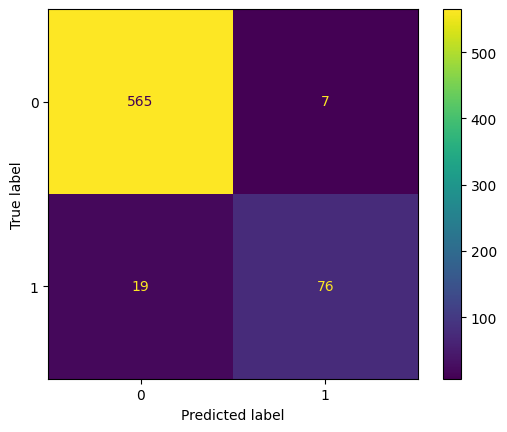

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_final, y_pred_meta)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [21]:
print(classification_report(y_test_final, y_pred_meta))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       572
           1       0.92      0.80      0.85        95

    accuracy                           0.96       667
   macro avg       0.94      0.89      0.92       667
weighted avg       0.96      0.96      0.96       667



In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba_meta)
fig = px.line(x=fpr,y=tpr,
        title="ROC Curve of Final LGBM Model"
              )

fig.update_layout(xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",)

fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy',name=f"AUC: {model_performance_final["roc_auc_score"]:.2f}"))
fig.show()

## Feature Importance - SHAP Plot

In [23]:
print(X_train_meta.shape)

print(X_test_meta.shape)

(2666, 3)
(667, 3)


In [24]:
X_train_base.columns

Index(['account_length', 'international_plan', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'intl_charge_per_min', 'total_minutes', 'total_calls',
       'daytime_charge_per_min', 'avg_charge_per_acc_day',
       'voicemail_engagement_lvl', 'customer_service_freq_lvl'],
      dtype='object')

In [25]:
for model_name in ['lgbm', 'xgb', 'cb']:
    print(f"SHAP summary plot for base model: {base_best_model[model_name]}")

SHAP summary plot for base model: LGBMClassifier(colsample_bytree=0.9561347875507571, max_depth=4,
               min_child_weight=5, n_estimators=112, random_state=42,
               reg_alpha=1, reg_lambda=0, scale_pos_weight=5.871134020618556)
SHAP summary plot for base model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9910955972619857, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05019049103849115,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=138, 

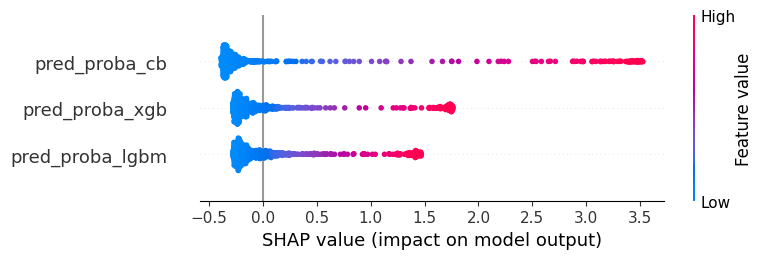

SHAP summary plot for base model: cb


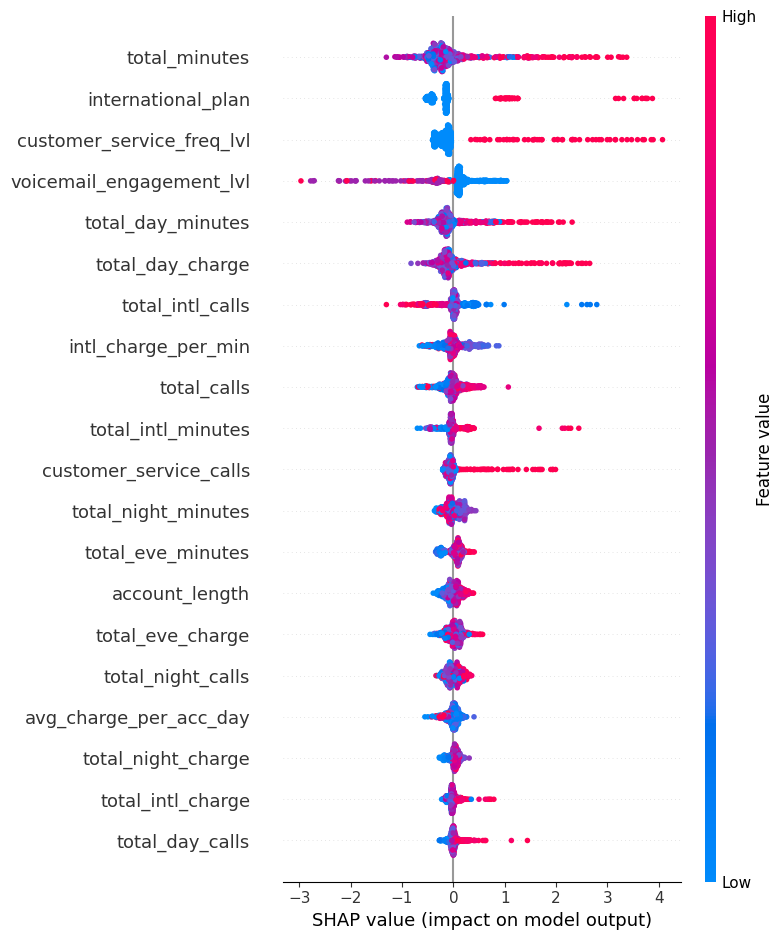

SHAP summary plot for base model: xgb


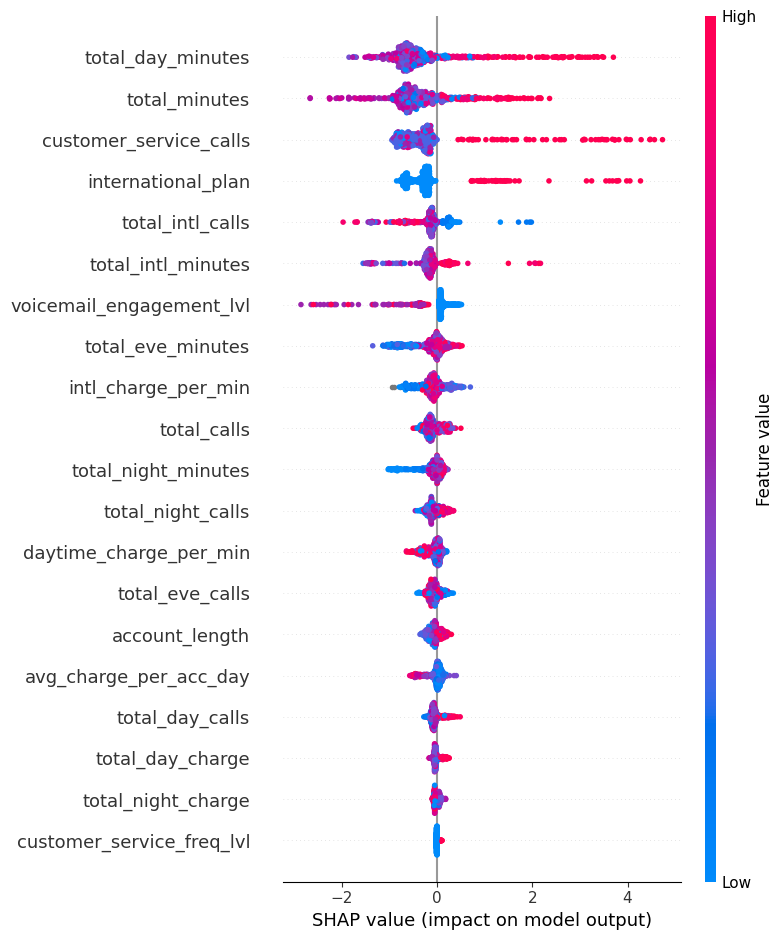

SHAP summary plot for base model: lgbm


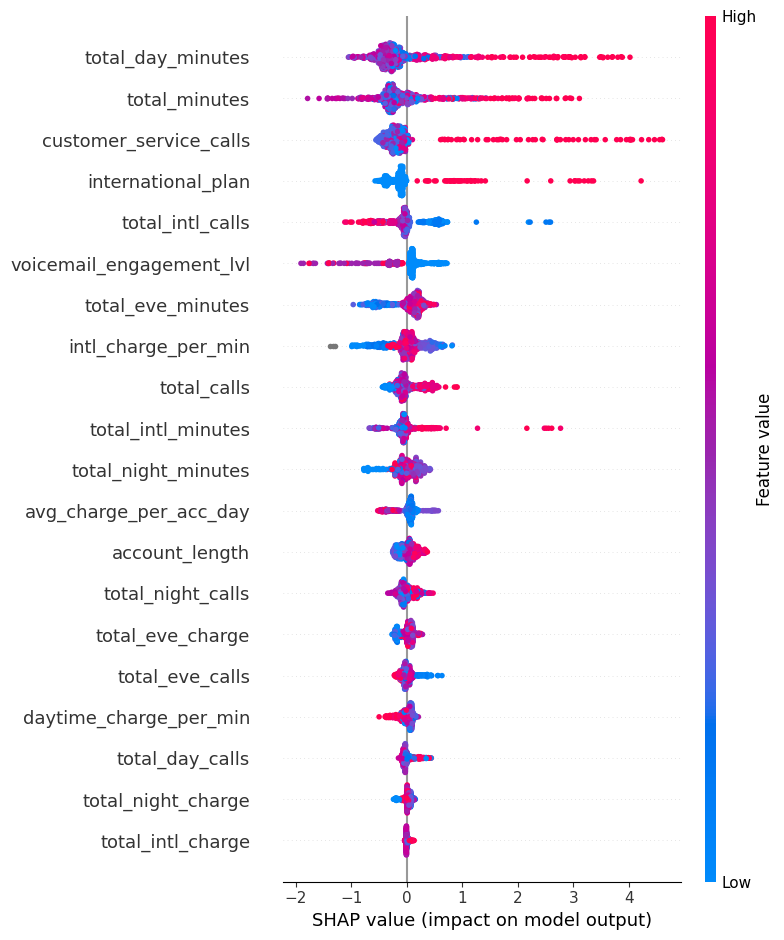

In [28]:
import shap

# SHAP for the Meta-Model
meta_explainer = shap.Explainer(meta_model, X_train_meta)
shap_values_meta = meta_explainer(X_test_meta)
shap.summary_plot(shap_values_meta, X_test_meta)

# SHAP for the Base Models
for i,model_name in enumerate(['cb', 'xgb', 'lgbm']):
    print(f"SHAP summary plot for base model: {model_name}")
    shap_values = shap.TreeExplainer(base_best_model[model_name]).shap_values(X_test_final)
    shap.summary_plot(shap_values, X_test_final)

## (Updated) A More Automated/Optimal Way to Train Stacked Model With Out-of-Fold Sets

In [4]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = X_train_final.copy(), X_test_final.copy(), y_train_final.copy(), y_test_final.copy()

# Define the scale_pos_weight parameter:
negative_count_final = np.sum(y_train_final == 0)
positive_count_final = np.sum(y_train_final == 1)
scale_pos_weight_final = negative_count_final / positive_count_final

# Define parameter space for BayesSearchCV
param_space_lgbm = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5)
}

param_space_xgb = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5),
    'tree_method': ['auto']
}

param_space_cb = {
    'iterations': (100, 200),
    'depth': (3, 10),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0, 1),
    'border_count': (32, 255),
}

# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm_search = BayesSearchCV(estimator=lgbm, search_spaces=param_space_lgbm, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_

# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_search = BayesSearchCV(estimator=xgb, search_spaces=param_space_xgb, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# CatBoost
cb = CatBoostClassifier(random_state=42, verbose=0)
cb_search = BayesSearchCV(estimator=cb, search_spaces=param_space_cb, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
cb_search.fit(X_train, y_train)
best_cb = cb_search.best_estimator_

stacking_clf = StackingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb),
        ('cb', best_cb)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Train and Evaluate Stacking Classifier
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred))


[LightGBM] [Info] Number of positive: 388, number of negative: 2278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145536 -> initscore=-1.770048
[LightGBM] [Info] Start training from score -1.770048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [42]:
stacking_clf_perf = {"accuracy_score": accuracy_score(y_test, y_pred),
                    "roc_auc_score": roc_auc_score(y_test, stacking_clf.predict_proba(X_test)[:, 1]),
                    "f1_score": f1_score(y_test, stacking_clf.predict(X_test))}

base_models_perf = {model_name: {"accuracy_score": accuracy_score(y_test, model.predict(X_test)),
                            "roc_auc_score": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
                            "f1_score": f1_score(y_test, model.predict(X_test))} for model_name, model in zip(["lgbm", "xgb", "cb"], [best_xgb, best_lgbm, best_cb])}

base_models_perf = pd.DataFrame(base_models_perf)

pd.DataFrame(stacking_clf_perf, index=["stacking"]).T.merge(base_models_perf, left_index=True, right_index=True)

,stacking,lgbm,xgb,cb
accuracy_score,0.962519,0.958021,0.961019,0.962519
roc_auc_score,0.929168,0.936732,0.936474,0.914961
f1_score,0.863388,0.847826,0.860215,0.858757


In [43]:
stacking_clf.named_estimators_.items()

dict_items([('lgbm', LGBMClassifier(colsample_bytree=0.8938186250780802, max_depth=7,
               min_child_weight=1, n_estimators=129, random_state=42,
               reg_alpha=1, reg_lambda=0, scale_pos_weight=5.871134020618556,
               subsample=0.8)), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.09960364026311894, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=161, n_jobs=None,
    

shap summary plot for final model: LogisticRegression(random_state=42)


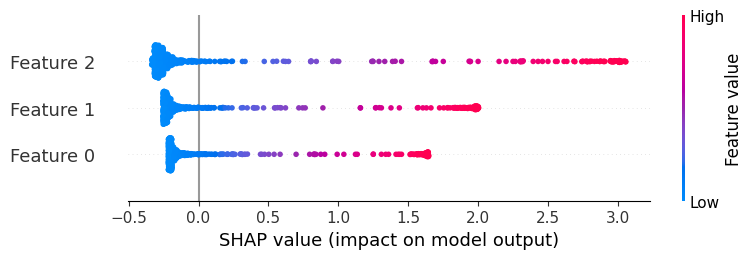

In [44]:
import shap
print(f"shap summary plot for final model: {stacking_clf.final_estimator_}")

# Create SHAP explainer for the meta-model
meta_explainer = shap.Explainer(stacking_clf.final_estimator_, stacking_clf.transform(X_train))

# Generate SHAP values for the test set (stacked features)
meta_test_features = stacking_clf.transform(X_test)
meta_shap_values = meta_explainer(meta_test_features)

# Plot SHAP summary plot for the meta-model
shap.summary_plot(meta_shap_values, meta_test_features)

SHAP plot for base model: cb


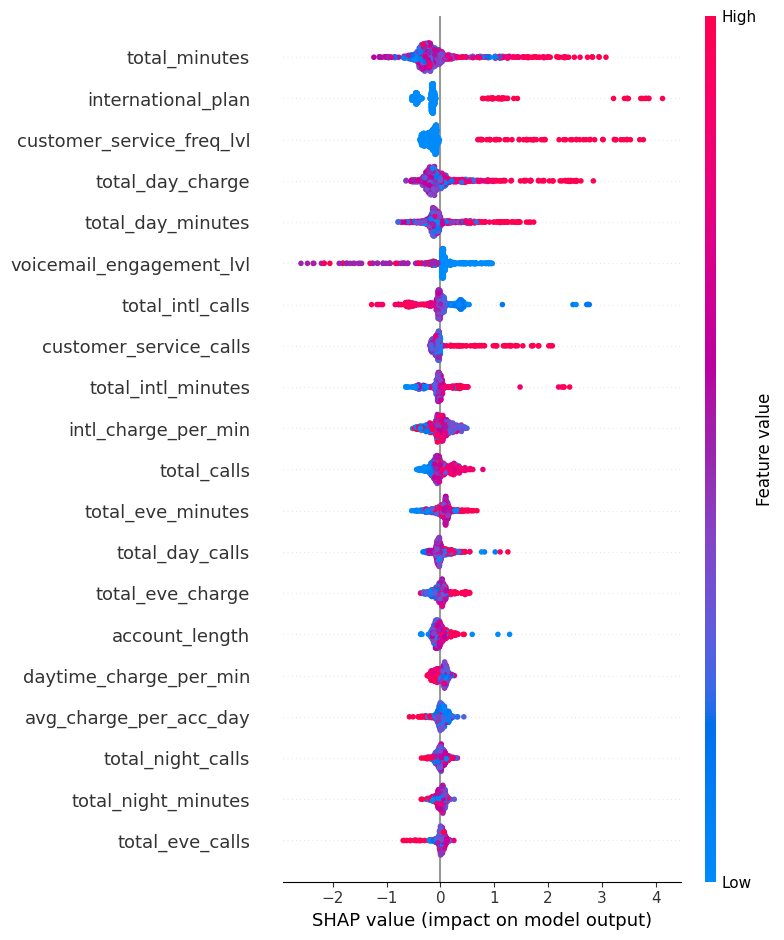

SHAP plot for base model: xgb


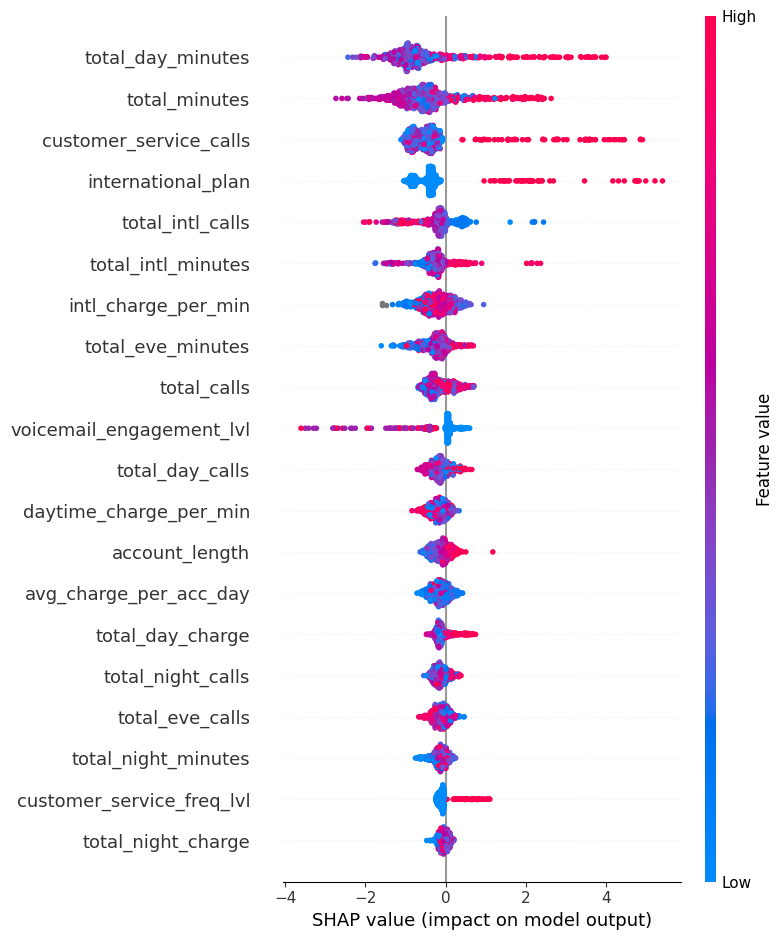

SHAP plot for base model: lgbm


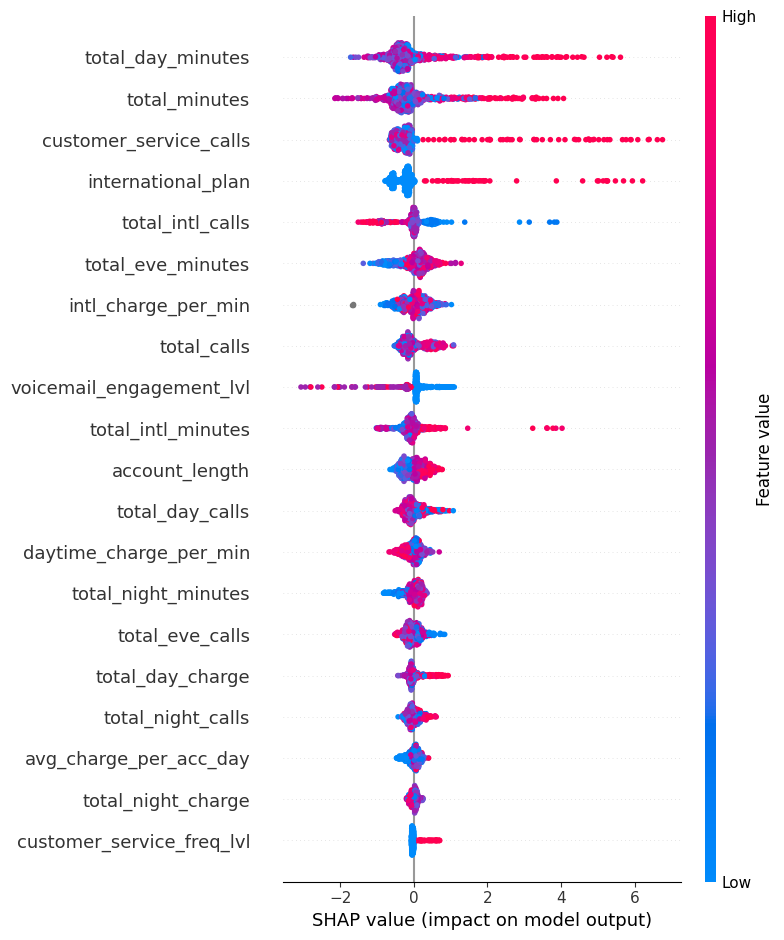

In [45]:
for model_name, model in list(stacking_clf.named_estimators_.items())[::-1]:
    print(f"SHAP plot for base model: {model_name}")
    shap_values = shap.TreeExplainer(model).shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

# Gain Chart - For Target Marketing

In [5]:
def create_gain_table(model, X, y, n_deciles=10):
    y_proba = model.predict_proba(X)[:, 1]
    data = pd.DataFrame({'actual': y, 'proba': y_proba})
    data = data.sort_values(by='proba', ascending=False).reset_index(drop=True)
    data['decile'] = pd.qcut(data.index, n_deciles, labels=False) + 1

    total_events = data['actual'].sum()
    overall_event_rate = total_events / len(data)

    gain_table = data.groupby('decile').agg(
        No_of_Observations=('actual', 'count'),
        Number_of_Events=('actual', 'sum'),
        Min_Probability=('proba', 'min'),
        Max_Probability=('proba', 'max')
    ).reset_index()


    gain_table['Event_Rate (%)'] = round((gain_table['Number_of_Events'] / gain_table['No_of_Observations']) * 100, 2)
    gain_table['Cumulative_Events'] = gain_table['Number_of_Events'].cumsum()
    gain_table['Cumulative_Response_Rate (%)'] = round((gain_table['Cumulative_Events'] / gain_table["No_of_Observations"].sum()) * 100, 2)
    gain_table['Cumulative_Gain (%)'] = round((gain_table['Cumulative_Events'] / total_events) * 100, 2)
    gain_table['Cumulative_Lift'] = round((gain_table['Cumulative_Events'] / gain_table["No_of_Observations"].cumsum()) / overall_event_rate, 2)

    # Rescale probability to 0–10000 and create Decile Range column
    gain_table['Min_Probability'] = (gain_table['Min_Probability'] * 10000).astype(int)
    gain_table['Max_Probability'] = (gain_table['Max_Probability'] * 10000).astype(int)
    gain_table['Propensity_Scorecard'] = gain_table['Min_Probability'].astype(str) + ' - ' + gain_table['Max_Probability'].astype(str)

    return gain_table[['decile','Propensity_Scorecard', 'No_of_Observations', 'Event_Rate (%)', 'Cumulative_Response_Rate (%)',
                       'Cumulative_Gain (%)', 'Cumulative_Lift']]

def plot_gain_chart(gain_table):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='decile', y='Cumulative_Gain (%)', data=gain_table, marker='o', label='Cumulative Gain')
    plt.plot(gain_table['decile'], gain_table['decile'] * (gain_table['Cumulative_Gain (%)'].max() / gain_table['decile'].max()),
             linestyle='--', color='grey', label='Random Model')
    plt.title('Gain Chart')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative Gain (%)')
    plt.xticks(gain_table['decile'])
    plt.legend()
    plt.show()

Gain Table:
+--------+----------------------+--------------------+----------------+------------------------------+---------------------+-----------------+
| decile | Propensity_Scorecard | No_of_Observations | Event_Rate (%) | Cumulative_Response_Rate (%) | Cumulative_Gain (%) | Cumulative_Lift |
+--------+----------------------+--------------------+----------------+------------------------------+---------------------+-----------------+
|   1    |     9283 - 9763      |         67         |     97.01      |             9.75             |        68.42        |      6.81       |
|   2    |      471 - 9192      |         67         |     25.37      |            12.29             |        86.32        |       4.3       |
|   3    |      304 - 468       |         66         |      1.52      |            12.44             |        87.37        |      2.91       |
|   4    |      272 - 304       |         67         |      5.97      |            13.04             |        91.58        |      

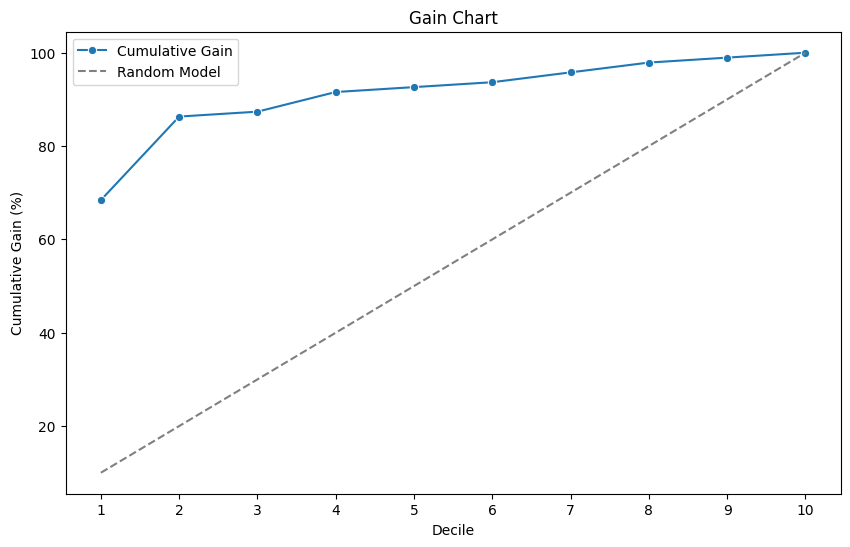

In [6]:
from tabulate import tabulate

gain_table = create_gain_table(stacking_clf.final_estimator_, stacking_clf.transform(X_test), y_test)
print("Gain Table:")
print(tabulate(gain_table, headers='keys', tablefmt='pretty', showindex=False))
print("\n")
print("---"*50)
print("\n")
plot_gain_chart(gain_table)

# Profit Curve - Target Marketing w/ Business Cost/Profit Schema

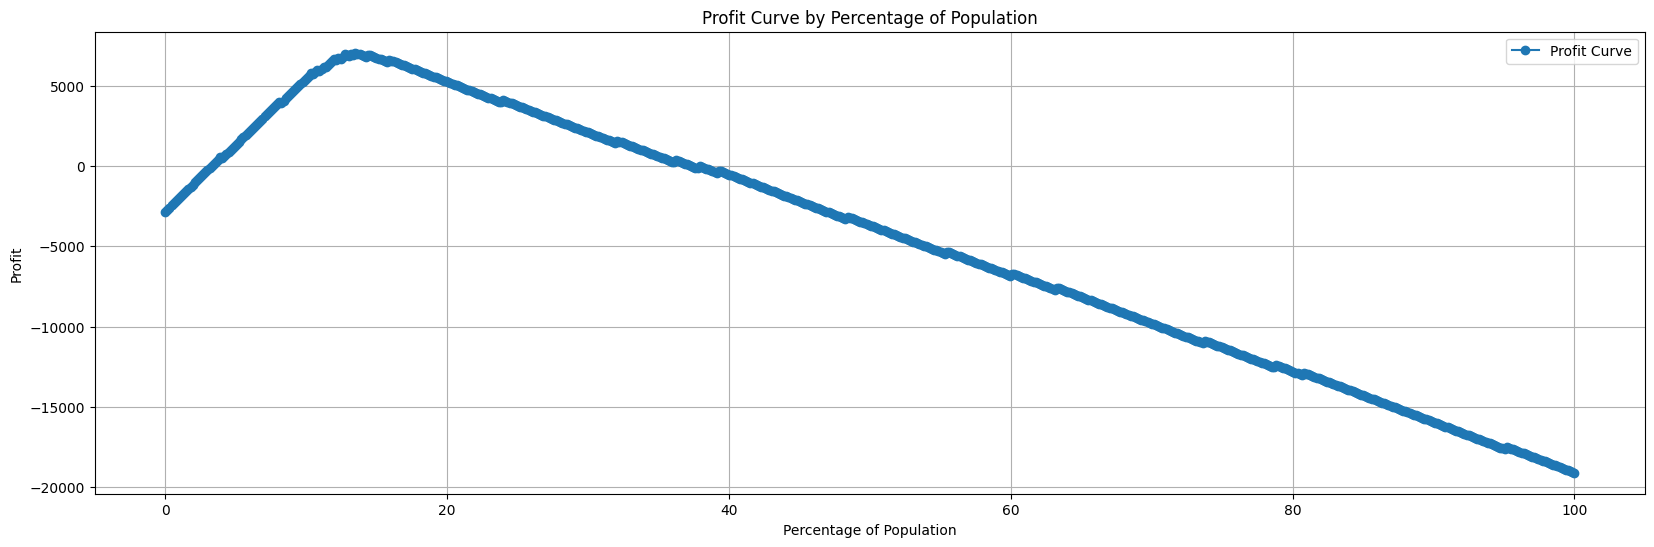

In [28]:
from sklearn.metrics import confusion_matrix

y_true = y_test.copy()
y_probs = stacking_clf.predict_proba(X_test)[:, 1]

def calculate_profit(tp, fp, fn, tn, profit_per_tp=100, cost_per_fp=50, cost_per_fn=30):
    """
    Custom profit calculation formula.
    Adjust profit/cost values as needed.
    """
    return (tp * profit_per_tp) - (fp * cost_per_fp) - (fn * cost_per_fn)

# Step 1: Sort probabilities and ground truth by predicted probabilities
sorted_indices = np.argsort(y_probs)[::-1]  # Sort indices in descending order
sorted_probs = np.array(y_probs)[sorted_indices]
sorted_true = np.array(y_true)[sorted_indices]

# Step 2: Calculate profits at different percentages of the population
population_percentages = np.linspace(0, 100, len(sorted_probs) + 1)
profits = []
thresholds = []

for i in range(len(sorted_probs) + 1):
    # Take the top 'i' instances as positive predictions
    y_pred = np.zeros_like(y_true)
    y_pred[sorted_indices[:i]] = 1  # Set top 'i' instances to 1
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate profit for the current population percentage
    profit = calculate_profit(tp, fp, fn, tn)
    profits.append(profit)
    
    # Add threshold for the top 'i' instances
    if i == 0:
        thresholds.append(None)  # No threshold for 0% population
    else:
        thresholds.append(sorted_probs[i - 1])  # Threshold is the probability of the last included instance

# Step 3: Plot the Profit Curve with Percentage of Population
plt.figure(figsize=(20, 6))
plt.plot(population_percentages, profits, label='Profit Curve', marker='o')
plt.title("Profit Curve by Percentage of Population")
plt.xlabel("Percentage of Population")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()

# Step 4: Annotate thresholds on the plot
# for i, txt in enumerate(thresholds):
#     if txt is not None:  # Skip None values
#         plt.annotate(f"{txt:.2f}", (population_percentages[i], profits[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_zoomed_profit_curve(y_true, y_probs, profit_per_tp=100, cost_per_fp=50, cost_per_fn=30, zoom_range=20):
    """
    Plots a zoomed profit curve for a classification model.
    
    Parameters:
    - y_true: List[int], ground truth binary labels (1 for positive, 0 for negative).
    - y_probs: List[float], predicted probabilities for the positive class.
    - profit_per_tp: int, profit for each true positive.
    - cost_per_fp: int, cost for each false positive.
    - cost_per_fn: int, cost for each false negative.
    - zoom_range: float, the upper limit for the population percentage to zoom into (default is 20%).
    
    Returns:
    - None. Displays a plot.
    """
    def calculate_profit(tp, fp, fn, tn, profit_per_tp=100, cost_per_fp=50, cost_per_fn=30):
        """Calculates profit using TP, FP, FN, and TN values."""
        return (tp * profit_per_tp) - (fp * cost_per_fp) - (fn * cost_per_fn)

    # Step 1: Sort probabilities and ground truth by predicted probabilities
    sorted_indices = np.argsort(y_probs)[::-1]  # Sort indices in descending order
    sorted_probs = np.array(y_probs)[sorted_indices]
    sorted_true = np.array(y_true)[sorted_indices]

    # Step 2: Calculate profits and thresholds
    population_percentages = np.linspace(0, 100, len(sorted_probs) + 1)
    profits = []
    thresholds = []

    for i in range(len(sorted_probs) + 1):
        # Take the top 'i' instances as positive predictions
        y_pred = np.zeros_like(y_true)
        y_pred[sorted_indices[:i]] = 1  # Set top 'i' instances to 1
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        profit = calculate_profit(tp, fp, fn, tn, profit_per_tp, cost_per_fp, cost_per_fn)
        profits.append(profit)
        
        # Add threshold for the top 'i' instances
        if i == 0:
            thresholds.append(None)  # No threshold for 0% population
        else:
            thresholds.append(sorted_probs[i - 1])  # last included instance

    # Step 3: Determine zoom range
    top_n = len(population_percentages[population_percentages < zoom_range])

    # Step 4: Plot the Profit Curve
    plt.figure(figsize=(15, 6))
    plt.plot(population_percentages[:top_n], profits[:top_n], label='Profit Curve', marker='o')
    plt.title(f"Profit Curve by Percentage of Population (Zoomed to Top {zoom_range}%)")
    plt.xlabel("Percentage of Population")
    plt.ylabel("Profit")
    plt.grid(True)
    plt.legend()
    
    # for i, txt in enumerate(thresholds[:top_n]):
    #     if txt is not None:  # Skip None values
    #         plt.annotate(f"{txt:.2f}", (population_percentages[i], profits[i]), textcoords="offset points", xytext=(0, 5), ha='center')
    
    plt.show()


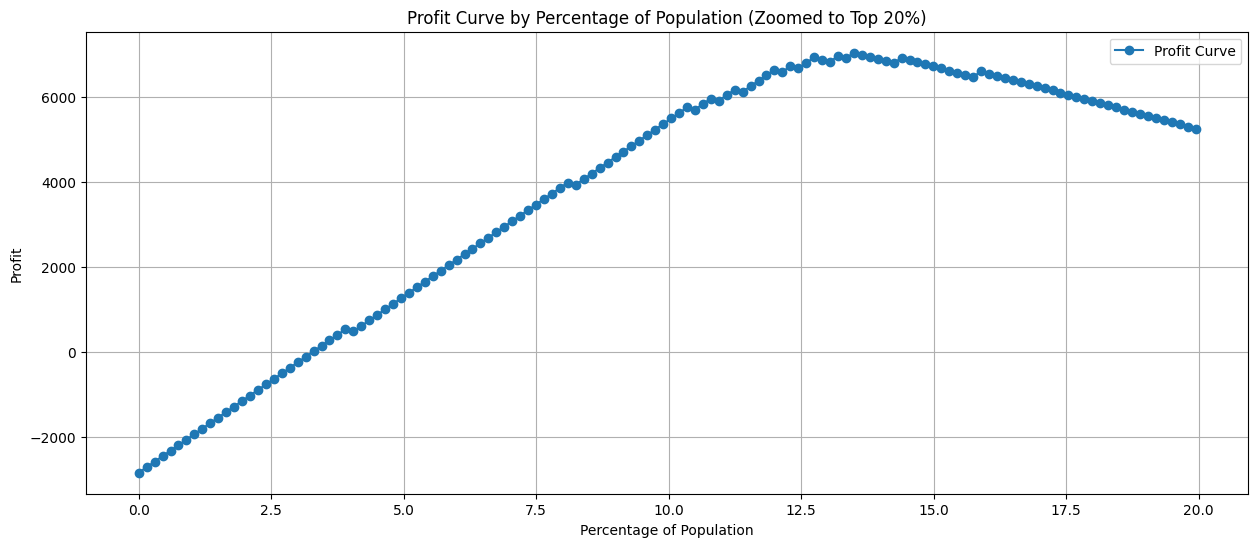

In [37]:
plot_zoomed_profit_curve(y_true, y_probs, profit_per_tp=100, cost_per_fp=50, cost_per_fn=30, zoom_range=20)

> Within the range of top 13-15% of population ranked by the classifier, the targeted marketing campaign may bring the highest profit for the business


**(Notice:** the benefit and cost for cases of fp, tp, fn, tn are being assumed, however, one can adjust according to the business plan)

--- 

# (Updated approach) Feature Subsets Extraction with Base Models &rarr; Fitting Meta Models

---

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

X_train, X_test, y_train, y_test = X_train_final.copy(), X_test_final.copy(), y_train_final.copy(), y_test_final.copy()


In [ ]:
def filter_redundant_features(model_name,model, X_train, y_train, X_test, y_test):
    """
     Function to filter redundant features
    """
    # Refit first

    model.fit(X_train, y_train)

    # Catboost
    if "cb" in model_name.lower():       
        feature_importance_gain = pd.DataFrame({
            'feature': X_train.columns,
            'importance_gain': model.get_feature_importance(
                type='LossFunctionChange',
                data=Pool(X_train, y_train)
            )
        }).sort_values(by='importance_gain', ascending=False).reset_index(drop=True)
        # XGB
    elif "xgb" in model_name.lower():
        feature_importances = model.get_booster().get_score(importance_type='total_gain')
        feature_importance_gain = pd.DataFrame({
            'feature': list(feature_importances.keys()),
            'importance_gain': list(feature_importances.values())
        }).sort_values(by='importance_gain', ascending=False).reset_index(drop=True)
    elif "lgbm" in model_name.lower():
        # LightGBM feature importance
        booster = model.booster_
        feature_importances = booster.feature_importance(importance_type='gain')
        features = booster.feature_name()
        feature_importance_gain = (
            pd.DataFrame({'feature': features, 'importance_gain': feature_importances})
            .sort_values(by='importance_gain', ascending=False)
            .reset_index(drop=True)
        )
    else:
        raise ValueError("Unsupported model type for feature importance calculation")

    retained_col = list(feature_importance_gain.feature)
    initial_col = list(feature_importance_gain.feature)
    roc_auc_scores = {}

    while True:
        current_auc = roc_auc_scores.get(len(retained_col), 0)

        if len(retained_col) >=8 or current_auc >= 0.9:
            # Retrain model
            model_retrain = model.fit(X_train[retained_col], y_train)
            y_pred_proba_retrained = model_retrain.predict_proba(X_test[retained_col])[:,1]
            
            retrain_auc = roc_auc_score(y_test, y_pred_proba_retrained)
            roc_auc_scores[len(retained_col)] = retrain_auc

            initial_auc = roc_auc_scores.get(len(initial_col), 0)
            if initial_auc - retrain_auc > 0.03:
                print(f"Performance dropped significantly after removing {len(initial_col) - len(retained_col)} features: {retrain_auc}")
            else:
                pass
            print(f"Retraining model with {len(retained_col)} features, AUC: {retrain_auc}")

            retained_col = retained_col[:-1]
        else:
            print(f"Stopping with final retained columns: {retained_col}")
            break

    auc_compare_df = pd.DataFrame(roc_auc_scores, index=["AUC"]).T.sort_values(by='AUC', ascending=False)
    auc_compare_df["drop in auc"] = auc_compare_df["AUC"].diff()
    print(f"Best feature set: {auc_compare_df.index[0]} with AUC: {auc_compare_df.iloc[0].AUC}")
    return auc_compare_df, feature_importance_gain, auc_compare_df.index[0]

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone

# Define a function to generate meta-features manually
def generate_meta_features(models, X, y, feature_subsets, cv=5):
    meta_features = np.zeros((X.shape[0], len(models))) 
    
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for i, (model_name, model) in enumerate(models.items()):
        feature_subset = feature_subsets[model_name]
        X_subset = X[feature_subset]
        
        for train_idx, val_idx in kf.split(X_subset, y):
            X_train, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
            y_train = y.iloc[train_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            
            # Generate predictions for the validation fold
            meta_features[val_idx, i] = model_clone.predict_proba(X_val)[:, 1]
    
    return meta_features


In [ ]:
# Setting hyperparameters space for tuning

from skopt.space import Real, Integer

negative_count_final = np.sum(y_train == 0)
positive_count_final = np.sum(y_train == 1)
scale_pos_weight_final = negative_count_final / positive_count_final

param_space_lgbm = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5)
}

param_space_xgb = {
    'n_estimators': (100, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'scale_pos_weight': (scale_pos_weight_final,),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'min_child_weight': (1, 5),
    'tree_method': ['auto']
}

param_space_cb = {
    'iterations': Integer(100, 200),
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),  # Regularization parameter
    'bagging_temperature': Real(0, 1),
    'border_count': Integer(32, 255),
}


In [ ]:
# Tuning models 

base_learners = {
    'lgbm': LGBMClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'cb': CatBoostClassifier(random_state=42, verbose=0)
}

# best final base estimator dict
best_est = {}

# best feature set dict for each base estimator
feature_subsets = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, param_space in zip(['lgbm', 'xgb', 'cb'], [param_space_lgbm, param_space_xgb, param_space_cb]):
    print(f"Hyperparameter tuning for {model_name}:")

    # Find best feature set
    search = BayesSearchCV(estimator=base_learners[model_name], search_spaces=param_space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42)
    search.fit(X_train, y_train)
    best_initial_model = search.best_estimator_
    print(f"Best initial model for {model_name}: {best_initial_model}")
    _ , best_featureset, number_keep = filter_redundant_features(model_name, best_initial_model, X_train, y_train, X_test, y_test)
    feature_subsets[model_name] = best_featureset.iloc[:number_keep].feature.tolist()

    print(f"Final best feature set for {model_name}: {feature_subsets[model_name]}")

    # Find best hyperparameters
    print("Refitting BayesSearchCV on the best feature set...")
    best_feats = feature_subsets[model_name]
    search.fit(X_train[best_feats], y_train)
    best_est[model_name] = search.best_estimator_
    print(f"Best hyperparameters for {model_name}: {search.best_params_}")
    print(f"Best score for {model_name}: {search.best_score_}")
    print("-" * 50)

Hyperparameter tuning for lgbm:
[LightGBM] [Info] Number of positive: 388, number of negative: 2278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3386
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145536 -> initscore=-1.770048
[LightGBM] [Info] Start training from score -1.770048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [ ]:
# Fitting meta-learner with meta features

meta_features_train = generate_meta_features(best_est, X_train, y_train, feature_subsets, cv=5)

# Train best base learners on the entire dataset for final meta-feature prediction
meta_features_test = np.zeros((X_test.shape[0], len(best_est)))
for i, (model_name, model) in enumerate(best_est.items()):
    feature_subset = feature_subsets[model_name]
    X_train_subset = X_train[feature_subset]
    X_test_subset = X_test[feature_subset]
    
    model.fit(X_train_subset, y_train) 
    meta_features_test[:, i] = model.predict_proba(X_test_subset)[:, 1]

best_est_test_perf = {}

# (added) Evaluate the base models on the test set
for model_name, model in best_est.items():
    feature_subset = feature_subsets[model_name]
    X_test_subset = X_test[feature_subset]
    
    y_base_pred = model.predict(X_test_subset)
    y_base_pred_proba = model.predict_proba(X_test_subset)[:, 1]
    
    best_est_test_perf[model_name] = {
        'accuracy_score': accuracy_score(y_test_final, y_base_pred),
        'f1_score': f1_score(y_test_final, y_base_pred),
        'roc_auc_score': roc_auc_score(y_test_final, y_base_pred_proba)
    }

# Train the meta-learner
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_features_train, y_train)

# Evaluate the final stacked model
y_pred = meta_model.predict(meta_features_test)
y_pred_proba = meta_model.predict_proba(meta_features_test)[:, 1]
stacking_clf_perf = {
    'accuracy_score': accuracy_score(y_test_final, y_pred),
    'f1_score': f1_score(y_test_final, y_pred),
    'roc_auc_score': roc_auc_score(y_test_final, y_pred_proba)
}

meta_vs_base_perf = pd.DataFrame(stacking_clf_perf,index=['stacking']).T.merge(pd.DataFrame(best_est_test_perf).rename(columns={0: 'base'}), right_index=True,left_index=True)
meta_vs_base_perf

[LightGBM] [Info] Number of positive: 310, number of negative: 1822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145403 -> initscore=-1.771118
[LightGBM] [Info] Start training from score -1.771118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,stacking,lgbm,xgb,cb
accuracy_score,0.958021,0.956522,0.950525,0.964018
f1_score,0.846154,0.841530,0.827225,0.865169
roc_auc_score,0.930162,0.938664,0.926684,0.916673


shap summary plot for final model: LogisticRegression(random_state=42)


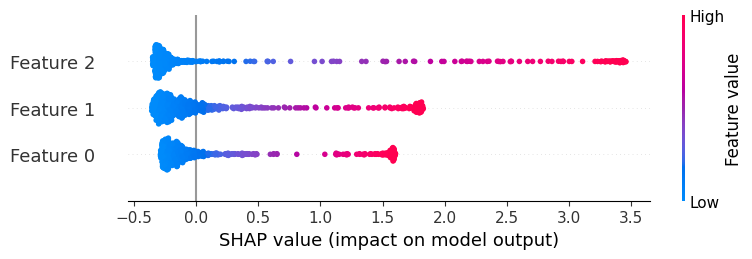

In [ ]:
import shap
print(f"shap summary plot for final model: {meta_model}")

# Create SHAP explainer for the meta-model
meta_explainer = shap.Explainer(meta_model, meta_features_train)

# Generate SHAP values for the test set (stacked features)
meta_shap_values = meta_explainer(meta_features_test)

# Plot SHAP summary plot for the meta-model
shap.summary_plot(meta_shap_values, meta_features_test)